<a href="https://colab.research.google.com/github/Joshua1030/APS360_Team17/blob/main/Primary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Loading and Splitting
Download data from kaggle and split them into train, validation, and test sets. Data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

Since the dataset contains about 10,000 images over 6 categories, it will take very long to train our model. Our team decide to randomly choose 500 images for training, 100 images for validation, and 100 images for testing, from each category. 
Datasets can be downloaded by link: https://drive.google.com/drive/folders/1vMEit7Gcn2ZQd1DnRtb2J6Gn7FbUQP4T?usp=share_link

In [6]:
#import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
#make sure to use the correct address
#Joshua
train_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Train"
val_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Val"
test_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Test"

In [10]:
#data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
classes = ('freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges')

#resize all images to 224x224
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

trainset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
valset = torchvision.datasets.ImageFolder(val_dir, transform=transform)
testset = torchvision.datasets.ImageFolder(test_dir, transform=transform)


#data loader
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=16, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16, num_workers=1, shuffle=True)

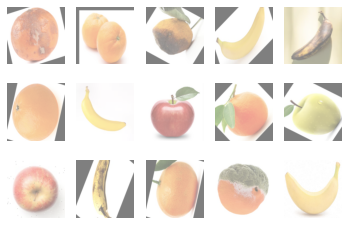

In [11]:
#Visualize data
k = 0
for images, labels in val_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    #print(labels)
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

Primary Model

In [12]:
#Convolutional Neural Network Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10*53*53, 32)
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*53*53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [13]:
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [14]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
fruit = CNN()
train(fruit, train_loader, val_loader, num_epochs=5, learning_rate=1e-4)